# Task 1 - Exploratory Data Analysis (EDA)
- This notebook aims to present the findings of my analysis, and also a detailed walkthrough of the steps taken to derive the results.

Outline of Steps

a. [Data Pre-processing](#data-pre-processing)

- [Preparing Database Files](#1-preparing-database-db-files)
- [Data Cleaning](#2-data-cleaning)

b.

# Data Pre-processing
**Purpose:**
- Get basic understanding of the structure, content and quality of the datasets
- Identify any missing data that may impact analysis
- Prepare or process the raw data to make it suitable for further analysis or modelling, by handling missing values, encoding categorical variables, and perform other necessary transformations

## 1. Preparing database ('.db') files

#### Use `sqlite3` library to prepare database ('.db') files

In [1]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Define a 'get database connection' function for reusability and readability

In [2]:
# Define a function that returns database connection object

def get_db_connection(url):
    conn = sqlite3.connect(url)        # points database connection object to conn
    conn.row_factory = sqlite3.Row     # set return rows as dictionaries instead of tuples
    return conn

#### Load **cruise_pre.db** and **cruise_post.db** into Python environment
- Dataset are read into a list of dictionaries, with each dictionary representing an individual row of data

- This is an intermediary step before converting to DataFrame

In [3]:
# Read cruise_pre.db and cruise_post.db into list of dictionaries

# Define required variables to store data from db
cruise_pre_data = []
cruise_post_data = []

# Define variable to store name of the tables
table_name = ['cruise_pre','cruise_post']

# Iterate through the 2 provided data sets: cruise_pre.db and cruise_post.db
for table in table_name:

    # Create connection to database using defined function
    conn = get_db_connection('data/'+ table + '.db')
    # Execute query to fetch all rows and columns
    data = conn.execute('SELECT * FROM {}'.format(table)).fetchall()

    # Append row to respective variable store
    if table == 'cruise_pre':
        for row in data:
            cruise_pre_data.append(dict(row))
    else:
        for row in data:
            cruise_post_data.append(dict(row))

# close database connection after completion of task
conn.close()

# Output: cruise_pre_data and cruise_post_data now contains list of dictionaries

#### Convert list of dict to Pandas DataFrame
- Convert to Pandas DataFrame objects as it unlocks a wide variety of simple and clean data analytics libraries

In [4]:
# Read list of dictionaries into Pandas Dataframe
# Set 'index' column as index
cruise_post_df = pd.DataFrame(data=cruise_post_data).set_index('index')
cruise_pre_df = pd.DataFrame(data=cruise_pre_data).set_index('index')

## 2. Data Cleaning

#### Dataset 1: Pre-cruise Customer Survey
Description
- This is a pre-purchase survey conducted to give ShipSail insights into what ameneties/services their customers prefer, or what is considered important to them for an enjoyable cruise journey.

Observation 1: **inconsistent scale across amenities**

- For example, `Onboard Wifi Service` has a categorical scale while `Ease of Online booking` has a numerical scale
- Implications: 
    1. inconsistent format makes data plotting across these variables difficult
    2. machine learning algorithms require numeric input variables
- Data handling suggestion:
    1. encode all categorical scale into corresponding numerical scale of 1.0 to 5.0

Observation 2: **missing values, or NaN fields**

- For example, `guest 133745` has 'NaN' for `Port Check-in Service`
- Implications:
    1. Similar to Observation 1
- Data handling suggestion:
    1. Removal can be an option, but substantial rows will have to be removed for this set
    2. Impute 'NaN' into median value of that column to keep more data points and minimize large spreads or inaccuracies


In [5]:
# Display part of cruise pre dataset
cruise_pre_df.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


#### Encoding Pre-cruise Survey
Encode categorical labels to numerical label because:
1. inconsistent format makes data plotting across these variables difficult
2. machine learning algorithms require numeric input variables

3 Scale Columns are categorically labelled: 
1. `Onboard Wifi Service`
2. `Onboard Entertainment`
3. `Onboard Dining Service`

In addition, these Guest Detail Column are categorically labelled as well:
1. `Gender`


Look for unique values within each column first.

In [6]:
# Summarise the unique values in this column
scale_summary = pd.concat([cruise_pre_df.groupby('Onboard Wifi Service').size(),
                        cruise_pre_df.groupby('Onboard Entertainment').size(),
                        cruise_pre_df.groupby('Onboard Dining Service').size()],
                        axis=1,
                        keys=['Wifi Service Count', 'Entertainment Count', 'Dining Service Count'])
scale_summary

,Wifi Service Count,Entertainment Count,Dining Service Count
A little important,29383,20009,24763
Extremely important,13031,28625,25149
Not at all important,20236,14205,14468
Somewhat important,29101,21627,25037
Very important,22503,33367,27520


In [7]:
# Based on the unique labels, there are no misspelling or outliers to be handled
# Note: NaN values are present but not displayed here

# Define a string to value map to help encode these columns
scale_map = {'Not at all important':1.0,
                'A little important':2.0,
                'Somewhat important':3.0,
                'Very important': 4.0,
                'Extremely important':5.0}

# Store columns to encode
encode_columns = ['Onboard Wifi Service', 'Onboard Entertainment', 'Onboard Dining Service']

# Iterate encoding for each column
for column in encode_columns:
    cruise_pre_df[column] = cruise_pre_df[column].map(scale_map)

For Gender, encode `Male` to 0 and `Female` to 1:

In [8]:
# Define a string to value map to encode gender column
gender_map = {'Male':0.0, 'Female':1.0}

# Encode 'Gender' column based on their gender
cruise_pre_df['Gender'] = cruise_pre_df['Gender'].map(gender_map)

In [9]:
# Summarise count of each source of traffic
cruise_pre_df.groupby('Source of Traffic').size()

Source of Traffic
Direct - Company Website    54591
Direct - Email Marketing    54645
Indirect - Search Engine    12288
Indirect - Social Media     12222
dtype: int64

In [10]:
# Define a string to value map to encode source of traffic column, based on the unique labels
traffic_map = {'Direct - Company Website':0.0,
               'Direct - Email Marketing':1.0,
               'Indirect - Search Engine':2.0,
               'Indirect - Social Media':3.0}

# Encode 'Source of Traffic' column
cruise_pre_df['Source of Traffic'] = cruise_pre_df['Source of Traffic'].map(traffic_map)

In [11]:
# Show part of the resulting dataframe
cruise_pre_df.head()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,NaN,05/10/1973,0.0,2.0,3.0,5.0,3.0,01/01/2023 0:00,4.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,1.0,None,3.0,1.0,4.0,1.0,NaN,01/01/2023 0:01,4.0,NaN,4.0,NaN,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,1.0,22/07/1998,2.0,NaN,3.0,0.0,5.0,01/01/2023 0:02,NaN,NaN,5.0,5.0,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,1.0,01/05/1970,0.0,4.0,4.0,4.0,4.0,01/01/2023 0:05,3.0,4.0,4.0,NaN,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,0.0,07/01/1960,0.0,3.0,4.0,2.0,NaN,01/01/2023 0:06,1.0,2.0,NaN,1.0,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


Results after encoding step:

**Scales, Gender and Source of Traffic that were in categorical scale are now in numerical scale.**

#### Handling Missing Values for Pre-cruise Survey

Assumptions:
- All missing values in data are missing at random (MAR)
- 'current' age is calculated relative to date of logging

**Scale Columns**
- For scale columns (where guests indicate their level of preference), we can replace NaN values with that column's most occuring importance, aka the `mode`.
- This approach leverages on available data to estimate the missing scales.
- Allows more data points to be kept, while also not skewing the data if extreme default values are used (e.g 0)
- `Mean` can be used too but since scales are whole numbers, `mode` is slightly more suited.

**Gender Column**
- Employ the same approach, replacing NaN fields with `mode` of `Gender` column

**Date of Birth Column**
- Calculate the age of guest, and fill missing age values with the `mean` age


##### Sensitivity Analysis on filling with `mode`, `mean` or `median` vs keeping `NaN`

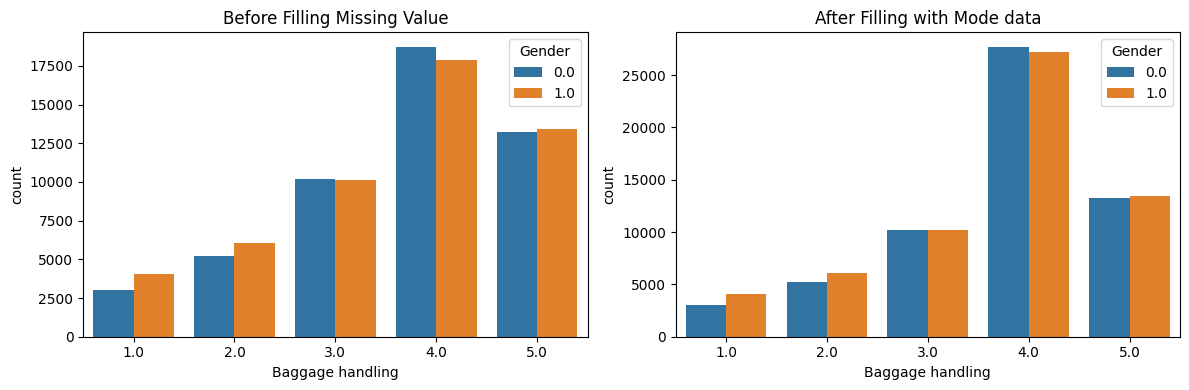

In [39]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

x_column = 'Baggage handling' # Change value here to view different column

# Ease of Online booking count plot without filling NaN values
plot1 = sns.countplot(data=cruise_pre_df,
                    x=x_column,
                    hue='Gender',
                    ax=axes[0])
plot1.set_title('Before Filling Missing Value')

# Create a temporary dataframe copy to perform missing data fill
adjusted_data = cruise_pre_df.copy()
adjusted_data[x_column].fillna(cruise_pre_df[x_column].mean().round(), inplace=True)


# Ease of Online booking count plot after filling with mode data
plot2 = sns.countplot(data=adjusted_data,
                    x=x_column,
                    hue='Gender',
                    ax=axes[1])
plot2.set_title('After Filling with Mode data')

plt.tight_layout()
plt.show()

##### Possible implications for filling with a single mean, mode or median value
- Across all scale columns comparison (Only 'Baggage handling' shown above), all graphs have an significant skew towards the filled rating, as seen on the 'After Filling with Mean data' count plot.

In [ ]:
# Define a list of column names that belongs to guest's scale rating
scale_columns = ['Onboard Wifi Service',
                 'Embarkation/Disembarkation time convenient',
                 'Ease of Online booking',
                 'Gate location',
                 'Onboard Dining Service',
                 'Online Check-in',
                 'Cabin Comfort',
                 'Onboard Entertainment',
                 'Cabin service',
                 'Baggage handling',
                 'Port Check-in Service',
                 'Onboard Service',
                 'Cleanliness']
# Iterate through each scale column, fill NaN fields with the mode of that column
# for column in scale_columns:
#     cruise_pre_df[column].fillna(cruise_pre_df[column].mode()[0], inplace=True)

# Similarly for Gender, fill NaN gender field with mode of the Gender column
# cruise_pre_df['Gender'].fillna(cruise_pre_df['Gender'].mode()[0], inplace=True)


**Resulting `cruise_pre_df` so far:**
- All scales are in proper numerical label, and missing values are filled via `mode` imputation
- Gender was assigned binary label (`Male` = 0, `Female` = 1), and missing values are filled via `mode` imputation
- Source of Traffic was ordinally labelled and missing values filled via `mode` imputation
    - `'Direct - Company Website':0.0`
    - `'Direct - Email Marketing':1.0`
    - `'Indirect - Search Engine':2.0`
    - `'Indirect - Social Media':3.0`

In [ ]:
# Show part of resulting cruise_pre_df
cruise_pre_df.head()

#### Date of Birth Column
To clean data in the `Date of Birth` column, we can derive the age of the guest in a new column, and then impute the new `Age` column instead

In [ ]:
# Define function to standardise format of date of birth
def convert_to_dmy(date_str):
    try:
        # If valid date is present, apply %d/%m/%Y format to date
        if date_str is not None:
            date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
            return date_obj.strftime('%d/%m/%Y')
        # If value is missing, skip
        else:
            return None
    # If value is missing, skip
    except ValueError:
        return None

# Apply function to every row in cruise_pre_df
cruise_pre_df['Date of Birth'] = cruise_pre_df['Date of Birth'].apply(convert_to_dmy)

# Add a new column 'Age', compute age by subtracting logging date by their date of birth, getting the quotient after dividing by 365
cruise_pre_df['Age'] = (pd.to_datetime(cruise_pre_df['Logging'], format='%d/%m/%Y %H:%M') - pd.to_datetime(cruise_pre_df['Date of Birth'], format='%d/%m/%Y')).dt.days // 365

# Fill the missing age values with the mean age, rounding to nearest integer
# cruise_pre_df['Age'].fillna(cruise_pre_df['Age'].median().round(), inplace=True)

In [ ]:
cruise_pre_df.head()

#### Dataset 2: Post-cruise Customer Data
Description
- This is a post-trip data collected by ShipSail to provide insights into the services or products that customers chosen in reality.

Observation 1: 

- For example,
- Implications: 

- Data cleaning process:

Observation 2: 

- For example,
- Implications:

- Data cleaning process:



In [ ]:
# Display part of cruise post dataset
cruise_post_df.info()

#### Data Cleaning and Imputation (Post-cruise Data)

# Analysis

In [ ]:
cruise_pre_df.head()

In [ ]:
online_booking = sns.countplot(data=cruise_pre_df, x = 'Ease of Online booking', hue='Gender')


In [ ]:
cruise_pre_df['Ease of Online booking'].fillna(cruise_pre_df['Ease of Online booking'].mode()[0], inplace=True)

In [ ]:
sns.countplot(data=cruise_pre_df, x = 'Ease of Online booking', hue='Gender')

In [ ]:
sns.displot(data=cruise_pre_df, kind='hist', x = 'Age', hue='Gender')

In [ ]:
penguins = sns.load_dataset('penguins')
sns.displot(data=penguins, x='flipper_length_mm')
